In [1]:
import anndata as ad
import gc
import sys
from scipy.sparse import csc_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LinearRegression
import random
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import pickle
import heapq
import matplotlib
import os

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

batch_size = 50000
pred_num = 6

cuda


In [3]:
train_mod1_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_train_mod1.h5ad'
train_mod2_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_train_mod2.h5ad'
test_mod1_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_test_mod1.h5ad'
test_mod2_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_test_mod2.h5ad'

In [4]:
input_train_mod1 = ad.read_h5ad(train_mod1_file)
input_train_mod2 = ad.read_h5ad(train_mod2_file)
input_test_mod1 = ad.read_h5ad(test_mod1_file)
input_test_mod2 = ad.read_h5ad(test_mod2_file)

In [5]:
print(input_train_mod1)
print(input_train_mod2)
print(input_test_mod1)
print(input_test_mod2)

AnnData object with n_obs × n_vars = 66175 × 13953
    obs: 'batch', 'size_factors'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 66175 × 134
    obs: 'batch', 'size_factors'
    var: 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1000 × 13953
    obs: 'batch', 'size_factors'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1000 × 134
    obs: 'batch', 'size_factors'
    var: 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'


In [6]:
print(sorted(set(input_train_mod1.obs['batch'])))
print(sorted(set(input_train_mod2.obs['batch'])))

['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']
['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']


In [7]:
print(sorted(set(input_test_mod1.obs['batch'])))
print(sorted(set(input_test_mod2.obs['batch'])))

['s4d1', 's4d8', 's4d9']
['s4d1', 's4d8', 's4d9']


In [8]:
RNA_s1d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d1", :]
RNA_s1d2 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d2", :]
RNA_s1d3 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d3", :]
RNA_s2d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d1", :]
RNA_s2d4 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d4", :]
RNA_s2d5 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d5", :]

RNA_s3d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d1", :]
RNA_s3d6 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d6", :]
RNA_s3d7 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d7", :]

In [9]:
pro_s1d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d1", :]
pro_s1d2 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d2", :]
pro_s1d3 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d3", :]
pro_s2d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d1", :]
pro_s2d4 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d4", :]
pro_s2d5 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d5", :]

pro_s3d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d1", :]
pro_s3d6 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d6", :]
pro_s3d7 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d7", :]

In [10]:
RNA_s4d1 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d1", :]
RNA_s4d8 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d8", :]
RNA_s4d9 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d9", :]

In [11]:
pro_s4d1 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d1", :]
pro_s4d8 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d8", :]
pro_s4d9 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d9", :]

In [12]:
RNA_s1d1 = RNA_s1d1.X.toarray()
RNA_s1d2 = RNA_s1d2.X.toarray()
RNA_s1d3 = RNA_s1d3.X.toarray()
RNA_s2d1 = RNA_s2d1.X.toarray()
RNA_s2d4 = RNA_s2d4.X.toarray()
RNA_s2d5 = RNA_s2d5.X.toarray()

RNA_s3d1 = RNA_s3d1.X.toarray()
RNA_s3d6 = RNA_s3d6.X.toarray()
RNA_s3d7 = RNA_s3d7.X.toarray()

In [13]:
pro_s1d1 = pro_s1d1.X.toarray()
pro_s1d2 = pro_s1d2.X.toarray()
pro_s1d3 = pro_s1d3.X.toarray()
pro_s2d1 = pro_s2d1.X.toarray()
pro_s2d4 = pro_s2d4.X.toarray()
pro_s2d5 = pro_s2d5.X.toarray()

pro_s3d1 = pro_s3d1.X.toarray()
pro_s3d6 = pro_s3d6.X.toarray()
pro_s3d7 = pro_s3d7.X.toarray()

In [14]:
RNA_s4d1 = RNA_s4d1.X.toarray()
RNA_s4d8 = RNA_s4d8.X.toarray()
RNA_s4d9 = RNA_s4d9.X.toarray()

In [15]:
pro_s4d1 = pro_s4d1.X.toarray()
pro_s4d8 = pro_s4d8.X.toarray()
pro_s4d9 = pro_s4d9.X.toarray()

In [16]:
print(RNA_s1d1.shape)
print(pro_s1d1.shape)

(4721, 13953)
(4721, 134)


In [17]:
print(RNA_s4d1.shape)
print(pro_s4d1.shape)

(334, 13953)
(334, 134)


In [18]:
batch_s1d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d1", :].obs["batch"]
batch_s1d2 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d2", :].obs["batch"]
batch_s1d3 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d3", :].obs["batch"]
batch_s2d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d1", :].obs["batch"]
batch_s2d4 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d4", :].obs["batch"]
batch_s2d5 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d5", :].obs["batch"]

batch_s3d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d1", :].obs["batch"]
batch_s3d6 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d6", :].obs["batch"]
batch_s3d7 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d7", :].obs["batch"]

batch_s4d1 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d1", :].obs["batch"]
batch_s4d8 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d8", :].obs["batch"]
batch_s4d9 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d9", :].obs["batch"]

In [19]:
batch_train = list(batch_s1d1)+list(batch_s1d2)+list(batch_s1d3)+list(batch_s2d1)+list(batch_s2d4)+list(batch_s2d5)
batch_val = list(batch_s3d1)+list(batch_s3d6)+list(batch_s3d7)
batch_test = list(batch_s4d1)+list(batch_s4d8)+list(batch_s4d9)

In [20]:
train_input = [RNA_s1d1, RNA_s1d2, RNA_s1d3, RNA_s2d1, RNA_s2d4, RNA_s2d5]
train_output = [pro_s1d1, pro_s1d2, pro_s1d3, pro_s2d1, pro_s2d4, pro_s2d5]

val_input = [RNA_s3d1, RNA_s3d6, RNA_s3d7]
val_output = [pro_s3d1, pro_s3d6, pro_s3d7]

test_input = [RNA_s4d1, RNA_s4d8, RNA_s4d9]
test_output = [pro_s4d1, pro_s4d8, pro_s4d9]

In [22]:
train_input = train_input + val_input
train_output = train_output + val_output

In [23]:
train_input = np.concatenate(train_input, axis=0)
val_input = np.concatenate(val_input, axis=0)
test_input = np.concatenate(test_input, axis=0)

train_output = np.concatenate(train_output, axis=0)
val_output = np.concatenate(val_output, axis=0)
test_output = np.concatenate(test_output, axis=0)

In [25]:
train_input = torch.from_numpy(train_input)
train_output = torch.from_numpy(train_output)
val_input = torch.from_numpy(val_input)
val_output = torch.from_numpy(val_output)
test_input = torch.from_numpy(test_input)
test_output = torch.from_numpy(test_output)

In [26]:
train_input = train_input.float()
train_output = train_output.float()
val_input = val_input.float()
val_output = val_output.float()
test_input = test_input.float()
test_output = test_output.float()

In [27]:
train_input = train_input.to(device)
train_output = train_output.to(device)
val_input = val_input.to(device)
val_output = val_output.to(device)
test_input = test_input.to(device)
test_output = test_output.to(device)

In [28]:
colors = ['red','green','blue','purple', 'yellow', 'orange']
k = 0
batch_lib = {}
for i in range(len(batch_train)):
    if batch_train[i] not in batch_lib:
        k = k + 1
        batch_lib[batch_train[i]] = k
    batch_train[i] = batch_lib[batch_train[i]]

In [29]:
colors = ['red','green','blue','purple', 'yellow', 'orange']
k = 0
batch_lib = {}
for i in range(len(batch_val)):
    if batch_val[i] not in batch_lib:
        k = k + 1
        batch_lib[batch_val[i]] = k
    batch_val[i] = batch_lib[batch_val[i]]

In [30]:
colors = ['red','green','blue','purple', 'yellow', 'orange']
k = 0
batch_lib = {}
for i in range(len(batch_test)):
    if batch_test[i] not in batch_lib:
        k = k + 1
        batch_lib[batch_test[i]] = k
    batch_test[i] = batch_lib[batch_test[i]]

In [31]:
batch_train = batch_train + batch_val

In [32]:
train_output = train_output[:, :pred_num+1]
train_output.shape

val_output = val_output[:, :pred_num+1]
val_output.shape

test_output = test_output[:, :pred_num+1]
test_output.shape

torch.Size([1000, 3])

In [33]:
train_ds = TensorDataset(train_input, train_output)
train_dl = DataLoader(train_ds, batch_size= batch_size, shuffle=True)

In [34]:
input_feature = train_input.shape[1]
output_feature = pred_num

In [35]:
# auto-encoder model
# base model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.linear1 = nn.Linear(input_feature, input_feature//16)
        self.linear2 = nn.Linear(input_feature//2, input_feature//4)
        self.linear3 = nn.Linear(input_feature//4, input_feature//8)
        self.linear4 = nn.Linear(input_feature//8, input_feature//16)
        
        self.linear5 = nn.Linear(input_feature//16, 3)
        self.relu = nn.ReLU()
        self.leakyrelu = nn.LeakyReLU(0.1)
        self.dropout = nn.Dropout(0.15)
        
        self.linear = nn.Linear(input_feature, 1)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
#         x = self.linear2(x)
#         x = self.relu(x)
#         x = self.dropout(x)
        
#         x = self.linear3(x)
#         x = self.relu(x)
        
#         x = self.linear4(x)
#         x = self.relu(x)
        
        output = self.linear5(x)
        
        return output.float()

In [36]:
PATH = 'Auto_No_norm_model_RNA_pro_' + str(pred_num) + '.pth'

In [38]:
losses = []

def fit(num_epochs, model, loss_fn, train_input, train_output, val_input, val_output, test_input, test_output):
    # plt.rcParams['figure.figsize'] = [40, 40]
    train_pred_output = []
    val_pred_output = []
    
    for epoch in range(num_epochs):
        for x,y in train_dl:
            model = model.train()
            pred = model(x)
            loss = loss_fn(pred, y)
            loss.backward()
            opt.step()
            opt.zero_grad()

        if epoch % 100 == 0:
            model = model.eval()
            temp_loss = [epoch]
            for i in range(6):
                # temp_loss = []
                train_pred = model(train_input)
                train_loss = loss_fn(train_pred[:, i], train_output[:, i])
                train_loss = torch.sqrt(train_loss)
                train_loss = train_loss.cpu().detach().numpy()

                # val_pred = model(val_input)
                # # val_output = torch.reshape(val_output, (val_output.shape[0], 1))
                # val_loss = loss_fn(val_pred[:, i], val_output[:, i])
                # val_loss = torch.sqrt(val_loss)
                # val_loss = val_loss.cpu().detach().numpy()

                test_pred = model(test_input)
                test_loss = loss_fn(test_pred[:, i], test_output[:, i])
                test_loss = torch.sqrt(test_loss)
                test_loss = test_loss.cpu().detach().numpy()
            
                temp_loss = temp_loss + [i, train_loss.cpu().detach().numpy(), test_loss.cpu().detach().numpy()]
                # temp_loss_sum.append(temp_loss)
                
            test_pred = model(test_input)
            # ((loss_1**2 + loss_2**2 + loss_3**2)/3)**0.5
            test_loss_total = loss_fn(test_pred, test_output)
            test_loss_total = torch.sqrt(test_loss_total)
            test_loss_total = test_loss_total.cpu().detach().numpy()
                
            print(temp_loss, 'total loss:', test_loss_total)
            losses.append(temp_loss)
            
        if epoch % 1000 == 0:
            colors = ['red','green','blue','purple', 'yellow', 'orange']
            figure, ax = plt.subplots(1, 6, figsize = (18, 3))
            for i in range(1):
                ax[0].scatter(train_output.cpu().detach().numpy()[:, 0], train_pred.cpu().detach().numpy()[:, 0], c=batch_train, cmap=matplotlib.colors.ListedColormap(colors), s = 30, alpha=0.3)
                ax[0].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[0].set_title('Train data result ' + str(0))
                ax[0].set_xlabel('train')
                ax[0].set_ylabel('pred')

                ax[1].scatter(test_output.cpu().detach().numpy()[:, 0], test_pred.cpu().detach().numpy()[:, 0], c=batch_test, cmap=matplotlib.colors.ListedColormap(colors), s = 30, alpha=0.3)
                ax[1].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[1].set_title('Test data result ' + str(0))
                ax[1].set_xlabel('true')
                ax[1].set_ylabel('pred')
                
                ax[2].scatter(train_output.cpu().detach().numpy()[:, 1], train_pred.cpu().detach().numpy()[:, 1], c=batch_train, cmap=matplotlib.colors.ListedColormap(colors), s = 30, alpha=0.3)
                ax[2].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[2].set_title('Train data result ' + str(1))
                ax[2].set_xlabel('train')
                ax[2].set_ylabel('pred')

                ax[3].scatter(test_output.cpu().detach().numpy()[:, 1], test_pred.cpu().detach().numpy()[:, 1], c=batch_test, cmap=matplotlib.colors.ListedColormap(colors), s = 30, alpha=0.3)
                ax[3].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[3].set_title('Test data result ' + str(1))
                ax[3].set_xlabel('true')
                ax[3].set_ylabel('pred')
                
                ax[4].scatter(train_output.cpu().detach().numpy()[:, 2], train_pred.cpu().detach().numpy()[:, 2], c=batch_train, cmap=matplotlib.colors.ListedColormap(colors), s = 30, alpha=0.3)
                ax[4].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[4].set_title('Train data result ' + str(2))
                ax[4].set_xlabel('train')
                ax[4].set_ylabel('pred')

                ax[5].scatter(test_output.cpu().detach().numpy()[:, 2], test_pred.cpu().detach().numpy()[:, 2], c=batch_test, cmap=matplotlib.colors.ListedColormap(colors), s = 30, alpha=0.3)
                ax[5].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[5].set_title('Test data result ' + str(2))
                ax[5].set_xlabel('true')
                ax[5].set_ylabel('pred')
                
            plt.show()
    return train_pred.cpu().detach().numpy(), train_output.cpu().detach().numpy(), val_pred.cpu().detach().numpy(), val_output.cpu().detach().numpy()

[[0, 0, array(0.38653895, dtype=float32), array(0.37492895, dtype=float32)], [0, 1, array(0.57275367, dtype=float32), array(0.8546148, dtype=float32)], [0, 2, array(0.8697553, dtype=float32), array(0.90279263, dtype=float32)]] 0.7496605


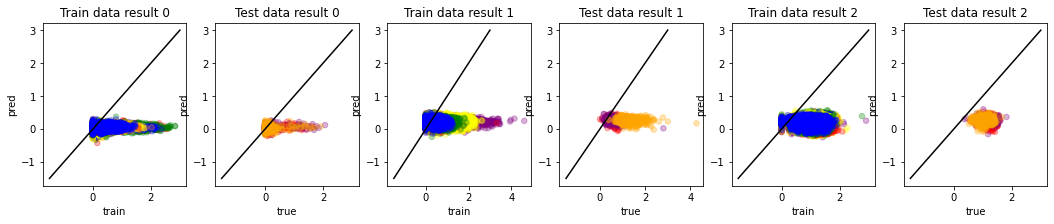

[[100, 0, array(0.23315476, dtype=float32), array(0.21679807, dtype=float32)], [100, 1, array(0.3972895, dtype=float32), array(0.62184167, dtype=float32)], [100, 2, array(0.33784124, dtype=float32), array(0.22917512, dtype=float32)]] 0.40257904
[[200, 0, array(0.22553745, dtype=float32), array(0.20990342, dtype=float32)], [200, 1, array(0.38526875, dtype=float32), array(0.6229613, dtype=float32)], [200, 2, array(0.3204509, dtype=float32), array(0.23021029, dtype=float32)]] 0.40213472
[[300, 0, array(0.220631, dtype=float32), array(0.20497133, dtype=float32)], [300, 1, array(0.37798518, dtype=float32), array(0.6184055, dtype=float32)], [300, 2, array(0.3102916, dtype=float32), array(0.22867455, dtype=float32)]] 0.39863545
[[400, 0, array(0.21695557, dtype=float32), array(0.20102414, dtype=float32)], [400, 1, array(0.37239888, dtype=float32), array(0.6159515, dtype=float32)], [400, 2, array(0.30313382, dtype=float32), array(0.22650556, dtype=float32)]] 0.39627922
[[500, 0, array(0.214017

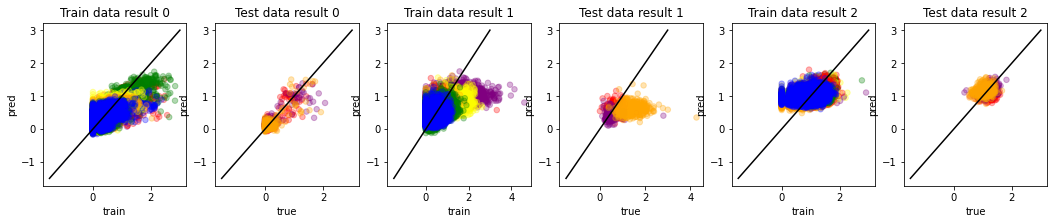

[[1100, 0, array(0.20364086, dtype=float32), array(0.18718763, dtype=float32)], [1100, 1, array(0.3492139, dtype=float32), array(0.6200419, dtype=float32)], [1100, 2, array(0.28078097, dtype=float32), array(0.21968964, dtype=float32)]] 0.39486483
[[1200, 0, array(0.20251048, dtype=float32), array(0.18619421, dtype=float32)], [1200, 1, array(0.3468919, dtype=float32), array(0.62145734, dtype=float32)], [1200, 2, array(0.27901697, dtype=float32), array(0.21943694, dtype=float32)]] 0.3954028
[[1300, 0, array(0.20147848, dtype=float32), array(0.18535016, dtype=float32)], [1300, 1, array(0.34468207, dtype=float32), array(0.62355006, dtype=float32)], [1300, 2, array(0.27737945, dtype=float32), array(0.21919003, dtype=float32)]] 0.3963221
[[1400, 0, array(0.20052424, dtype=float32), array(0.18451546, dtype=float32)], [1400, 1, array(0.34256187, dtype=float32), array(0.62152314, dtype=float32)], [1400, 2, array(0.27584878, dtype=float32), array(0.21900144, dtype=float32)]] 0.39509434
[[1500, 0

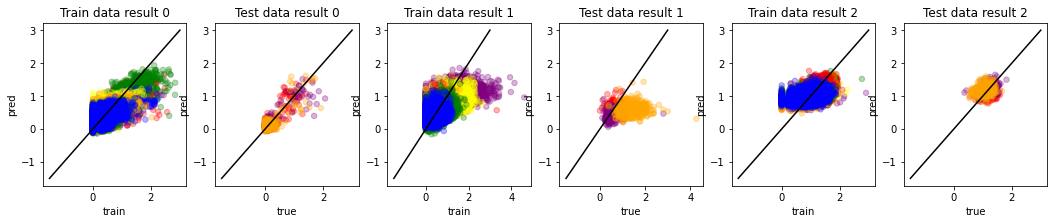

[[2100, 0, array(0.19524102, dtype=float32), array(0.18039025, dtype=float32)], [2100, 1, array(0.32935697, dtype=float32), array(0.63066286, dtype=float32)], [2100, 2, array(0.26714268, dtype=float32), array(0.21831256, dtype=float32)]] 0.39913934
[[2200, 0, array(0.19460778, dtype=float32), array(0.1799824, dtype=float32)], [2200, 1, array(0.327616, dtype=float32), array(0.63114244, dtype=float32)], [2200, 2, array(0.2660957, dtype=float32), array(0.21819444, dtype=float32)]] 0.3993091
[[2300, 0, array(0.19400759, dtype=float32), array(0.17949097, dtype=float32)], [2300, 1, array(0.32589602, dtype=float32), array(0.6325495, dtype=float32)], [2300, 2, array(0.26507813, dtype=float32), array(0.21814978, dtype=float32)]] 0.39996883
[[2400, 0, array(0.19341598, dtype=float32), array(0.17918436, dtype=float32)], [2400, 1, array(0.32421577, dtype=float32), array(0.6358335, dtype=float32)], [2400, 2, array(0.2640895, dtype=float32), array(0.2181991, dtype=float32)]] 0.40166408
[[2500, 0, ar

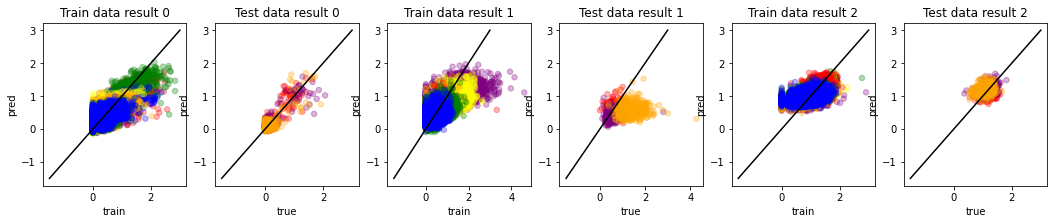

[[3100, 0, array(0.18966255, dtype=float32), array(0.1774478, dtype=float32)], [3100, 1, array(0.31274194, dtype=float32), array(0.6412096, dtype=float32)], [3100, 2, array(0.25780737, dtype=float32), array(0.21847968, dtype=float32)]] 0.40429807
[[3200, 0, array(0.18916419, dtype=float32), array(0.1773412, dtype=float32)], [3200, 1, array(0.31113482, dtype=float32), array(0.64059955, dtype=float32)], [3200, 2, array(0.25697425, dtype=float32), array(0.21859023, dtype=float32)]] 0.4039799
[[3300, 0, array(0.18867823, dtype=float32), array(0.17718174, dtype=float32)], [3300, 1, array(0.30954903, dtype=float32), array(0.6430993, dtype=float32)], [3300, 2, array(0.2561475, dtype=float32), array(0.21873473, dtype=float32)]] 0.40530437
[[3400, 0, array(0.18819694, dtype=float32), array(0.17696324, dtype=float32)], [3400, 1, array(0.30795634, dtype=float32), array(0.6431209, dtype=float32)], [3400, 2, array(0.25533172, dtype=float32), array(0.21895288, dtype=float32)]] 0.40532324
[[3500, 0, 

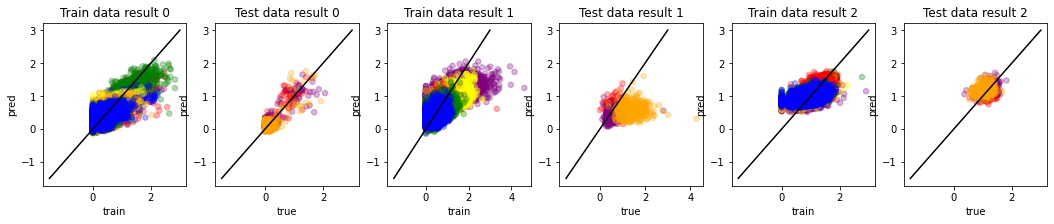

[[4100, 0, array(0.18500301, dtype=float32), array(0.17630365, dtype=float32)], [4100, 1, array(0.29691982, dtype=float32), array(0.6480064, dtype=float32)], [4100, 2, array(0.2498403, dtype=float32), array(0.21986267, dtype=float32)]] 0.40797663
[[4200, 0, array(0.18456577, dtype=float32), array(0.17630576, dtype=float32)], [4200, 1, array(0.29535192, dtype=float32), array(0.6506703, dtype=float32)], [4200, 2, array(0.24906933, dtype=float32), array(0.22014369, dtype=float32)]] 0.40943816
[[4300, 0, array(0.18412729, dtype=float32), array(0.176323, dtype=float32)], [4300, 1, array(0.29376367, dtype=float32), array(0.650155, dtype=float32)], [4300, 2, array(0.24830566, dtype=float32), array(0.22035193, dtype=float32)]] 0.40920502
[[4400, 0, array(0.18369651, dtype=float32), array(0.17619012, dtype=float32)], [4400, 1, array(0.2921958, dtype=float32), array(0.6502867, dtype=float32)], [4400, 2, array(0.24754077, dtype=float32), array(0.22058122, dtype=float32)]] 0.40929687
[[4500, 0, ar

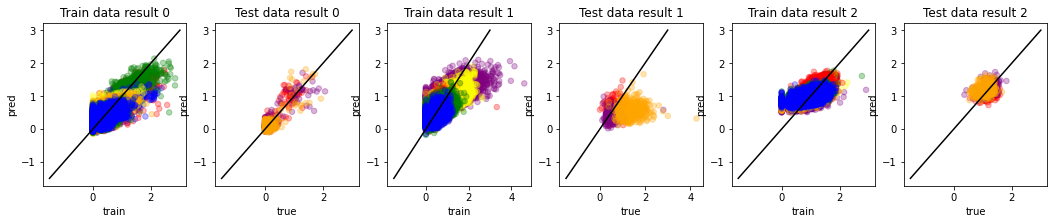

[[5100, 0, array(0.18073764, dtype=float32), array(0.17626555, dtype=float32)], [5100, 1, array(0.28107306, dtype=float32), array(0.65459114, dtype=float32)], [5100, 2, array(0.24220605, dtype=float32), array(0.22218633, dtype=float32)]] 0.41187617
[[5200, 0, array(0.18032661, dtype=float32), array(0.1761498, dtype=float32)], [5200, 1, array(0.27947584, dtype=float32), array(0.6567337, dtype=float32)], [5200, 2, array(0.2414449, dtype=float32), array(0.22231968, dtype=float32)]] 0.41301894
[[5300, 0, array(0.17990978, dtype=float32), array(0.17629658, dtype=float32)], [5300, 1, array(0.27786502, dtype=float32), array(0.6568463, dtype=float32)], [5300, 2, array(0.24067889, dtype=float32), array(0.22251076, dtype=float32)]] 0.41313377
[[5400, 0, array(0.1794952, dtype=float32), array(0.17638324, dtype=float32)], [5400, 1, array(0.27625334, dtype=float32), array(0.657437, dtype=float32)], [5400, 2, array(0.23990753, dtype=float32), array(0.22297303, dtype=float32)]] 0.41354218
[[5500, 0, 

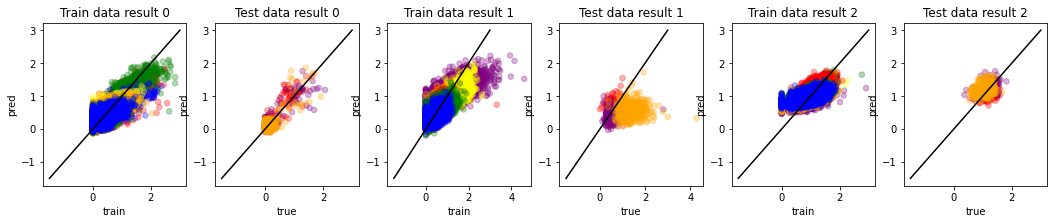

[[6100, 0, array(0.17663777, dtype=float32), array(0.17673315, dtype=float32)], [6100, 1, array(0.26488286, dtype=float32), array(0.66211134, dtype=float32)], [6100, 2, array(0.23444836, dtype=float32), array(0.22490893, dtype=float32)]] 0.41641727
[[6200, 0, array(0.17623211, dtype=float32), array(0.17695925, dtype=float32)], [6200, 1, array(0.2632431, dtype=float32), array(0.6626135, dtype=float32)], [6200, 2, array(0.23365709, dtype=float32), array(0.22505581, dtype=float32)]] 0.4167419
[[6300, 0, array(0.17582545, dtype=float32), array(0.17685965, dtype=float32)], [6300, 1, array(0.26159143, dtype=float32), array(0.66135067, dtype=float32)], [6300, 2, array(0.23285693, dtype=float32), array(0.22547789, dtype=float32)]] 0.41613472
[[6400, 0, array(0.17542325, dtype=float32), array(0.1768964, dtype=float32)], [6400, 1, array(0.2599463, dtype=float32), array(0.6637748, dtype=float32)], [6400, 2, array(0.23206489, dtype=float32), array(0.22575563, dtype=float32)]] 0.41747448
[[6500, 0,

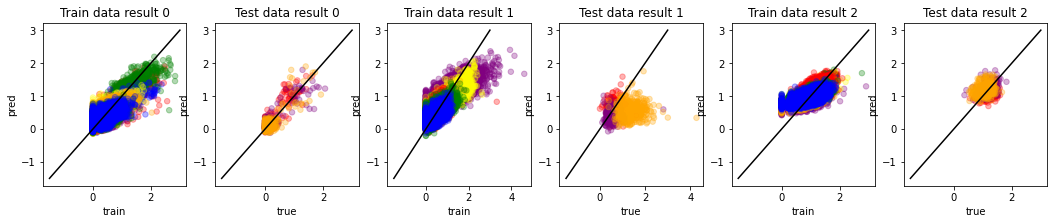

[[7100, 0, array(0.17260453, dtype=float32), array(0.17753975, dtype=float32)], [7100, 1, array(0.24830876, dtype=float32), array(0.66614044, dtype=float32)], [7100, 2, array(0.22635081, dtype=float32), array(0.2277932, dtype=float32)]] 0.41918698
[[7200, 0, array(0.17219685, dtype=float32), array(0.17778885, dtype=float32)], [7200, 1, array(0.24664058, dtype=float32), array(0.6650065, dtype=float32)], [7200, 2, array(0.22551444, dtype=float32), array(0.22805567, dtype=float32)]] 0.41866928
[[7300, 0, array(0.17179544, dtype=float32), array(0.178056, dtype=float32)], [7300, 1, array(0.24496299, dtype=float32), array(0.66628975, dtype=float32)], [7300, 2, array(0.22467832, dtype=float32), array(0.22839738, dtype=float32)]] 0.41944855
[[7400, 0, array(0.1713938, dtype=float32), array(0.17798817, dtype=float32)], [7400, 1, array(0.2432902, dtype=float32), array(0.6660809, dtype=float32)], [7400, 2, array(0.22383349, dtype=float32), array(0.22876418, dtype=float32)]] 0.419395
[[7500, 0, ar

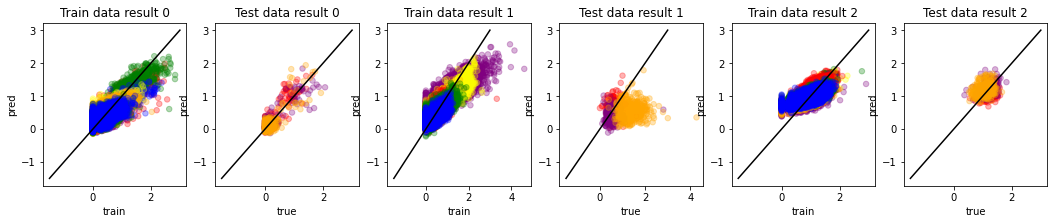

[[8100, 0, array(0.16856071, dtype=float32), array(0.17903593, dtype=float32)], [8100, 1, array(0.23153694, dtype=float32), array(0.6701816, dtype=float32)], [8100, 2, array(0.21780926, dtype=float32), array(0.23089126, dtype=float32)]] 0.42210108
[[8200, 0, array(0.16815464, dtype=float32), array(0.17906818, dtype=float32)], [8200, 1, array(0.22985218, dtype=float32), array(0.66894436, dtype=float32)], [8200, 2, array(0.2169245, dtype=float32), array(0.23133592, dtype=float32)]] 0.4215322
[[8300, 0, array(0.16774651, dtype=float32), array(0.17938347, dtype=float32)], [8300, 1, array(0.22817908, dtype=float32), array(0.6701133, dtype=float32)], [8300, 2, array(0.21604116, dtype=float32), array(0.23176482, dtype=float32)]] 0.42227373
[[8400, 0, array(0.16733818, dtype=float32), array(0.17950103, dtype=float32)], [8400, 1, array(0.22649197, dtype=float32), array(0.6693388, dtype=float32)], [8400, 2, array(0.21514998, dtype=float32), array(0.23183519, dtype=float32)]] 0.4218936
[[8500, 0,

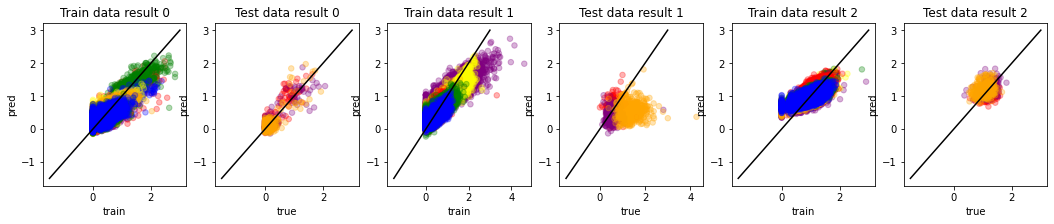

[[9100, 0, array(0.16447105, dtype=float32), array(0.18058594, dtype=float32)], [9100, 1, array(0.21478197, dtype=float32), array(0.67312795, dtype=float32)], [9100, 2, array(0.20879449, dtype=float32), array(0.23413603, dtype=float32)]] 0.42447305
[[9200, 0, array(0.16405864, dtype=float32), array(0.18076962, dtype=float32)], [9200, 1, array(0.21311152, dtype=float32), array(0.6709589, dtype=float32)], [9200, 2, array(0.20786661, dtype=float32), array(0.23446074, dtype=float32)]] 0.42341283
[[9300, 0, array(0.16364515, dtype=float32), array(0.18103378, dtype=float32)], [9300, 1, array(0.21145286, dtype=float32), array(0.67414397, dtype=float32)], [9300, 2, array(0.20693362, dtype=float32), array(0.2350921, dtype=float32)]] 0.42524958
[[9400, 0, array(0.16323033, dtype=float32), array(0.18119001, dtype=float32)], [9400, 1, array(0.2098014, dtype=float32), array(0.67430353, dtype=float32)], [9400, 2, array(0.20600155, dtype=float32), array(0.23542485, dtype=float32)]] 0.42541736
[[9500,

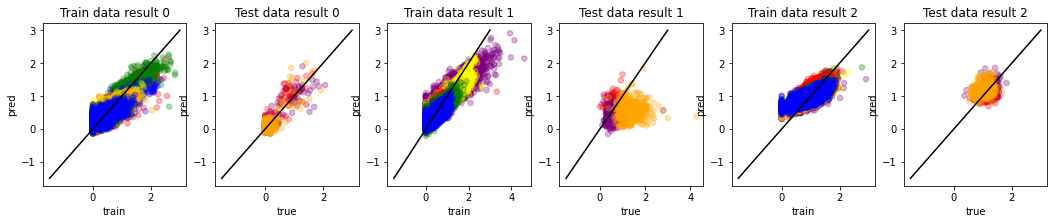

[[10100, 0, array(0.16031311, dtype=float32), array(0.18246819, dtype=float32)], [10100, 1, array(0.19830464, dtype=float32), array(0.67464656, dtype=float32)], [10100, 2, array(0.19933535, dtype=float32), array(0.23774186, dtype=float32)]] 0.42620954
[[10200, 0, array(0.1598948, dtype=float32), array(0.18252529, dtype=float32)], [10200, 1, array(0.19668926, dtype=float32), array(0.67356473, dtype=float32)], [10200, 2, array(0.19837031, dtype=float32), array(0.23795477, dtype=float32)]] 0.42568663
[[10300, 0, array(0.1594723, dtype=float32), array(0.18277064, dtype=float32)], [10300, 1, array(0.19508134, dtype=float32), array(0.67365736, dtype=float32)], [10300, 2, array(0.19739741, dtype=float32), array(0.23820311, dtype=float32)]] 0.4258169
[[10400, 0, array(0.15905474, dtype=float32), array(0.18282734, dtype=float32)], [10400, 1, array(0.19348828, dtype=float32), array(0.67662126, dtype=float32)], [10400, 2, array(0.19642396, dtype=float32), array(0.23859687, dtype=float32)]] 0.4274

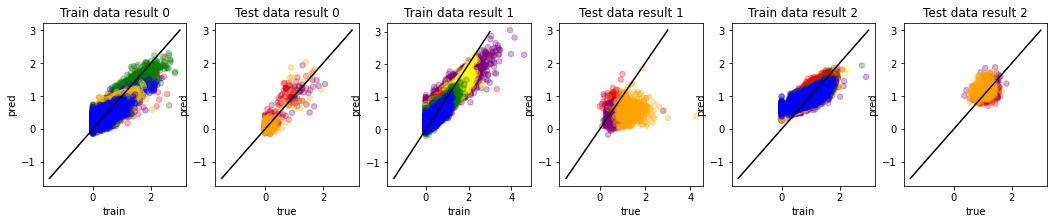

[[11100, 0, array(0.15607779, dtype=float32), array(0.18426982, dtype=float32)], [11100, 1, array(0.18241177, dtype=float32), array(0.67449117, dtype=float32)], [11100, 2, array(0.18949737, dtype=float32), array(0.24069448, dtype=float32)]] 0.42693773
[[11200, 0, array(0.155653, dtype=float32), array(0.18441473, dtype=float32)], [11200, 1, array(0.18086623, dtype=float32), array(0.6777754, dtype=float32)], [11200, 2, array(0.18850276, dtype=float32), array(0.24105951, dtype=float32)]] 0.42875707
[[11300, 0, array(0.15522057, dtype=float32), array(0.184664, dtype=float32)], [11300, 1, array(0.17930432, dtype=float32), array(0.67596126, dtype=float32)], [11300, 2, array(0.18749823, dtype=float32), array(0.24126002, dtype=float32)]] 0.42787486
[[11400, 0, array(0.15479188, dtype=float32), array(0.18474062, dtype=float32)], [11400, 1, array(0.17778313, dtype=float32), array(0.6750467, dtype=float32)], [11400, 2, array(0.18649627, dtype=float32), array(0.24146679, dtype=float32)]] 0.4274432

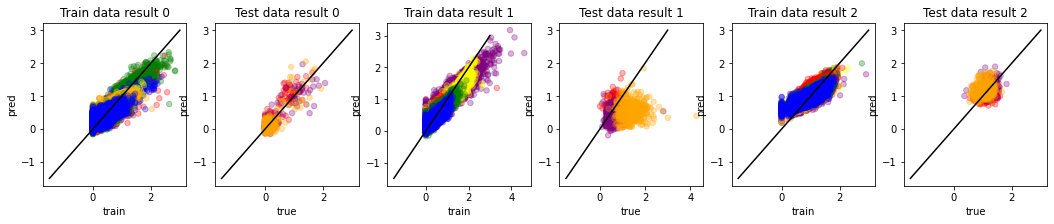

[[12100, 0, array(0.15176424, dtype=float32), array(0.18608458, dtype=float32)], [12100, 1, array(0.16728468, dtype=float32), array(0.67769766, dtype=float32)], [12100, 2, array(0.17941369, dtype=float32), array(0.24368167, dtype=float32)]] 0.42945015
[[12200, 0, array(0.1513268, dtype=float32), array(0.18625651, dtype=float32)], [12200, 1, array(0.1658185, dtype=float32), array(0.67863524, dtype=float32)], [12200, 2, array(0.17839365, dtype=float32), array(0.24412872, dtype=float32)]] 0.43005273
[[12300, 0, array(0.15089414, dtype=float32), array(0.1864351, dtype=float32)], [12300, 1, array(0.16436721, dtype=float32), array(0.67771196, dtype=float32)], [12300, 2, array(0.17737332, dtype=float32), array(0.24418353, dtype=float32)]] 0.42960334
[[12400, 0, array(0.15045013, dtype=float32), array(0.18681622, dtype=float32)], [12400, 1, array(0.16293769, dtype=float32), array(0.6765406, dtype=float32)], [12400, 2, array(0.17634274, dtype=float32), array(0.244709, dtype=float32)]] 0.4291425

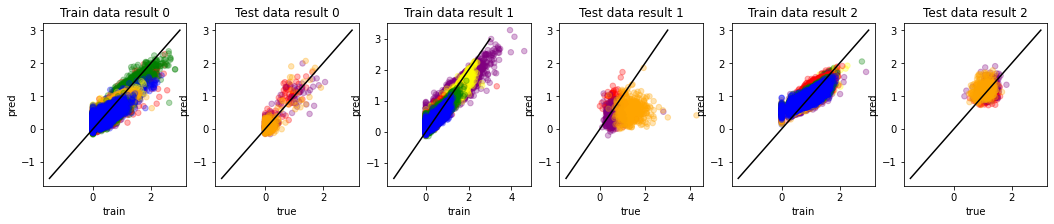

[[13100, 0, array(0.14737186, dtype=float32), array(0.18797922, dtype=float32)], [13100, 1, array(0.15314485, dtype=float32), array(0.68021137, dtype=float32)], [13100, 2, array(0.1691862, dtype=float32), array(0.24648602, dtype=float32)]] 0.43157813
[[13200, 0, array(0.14692841, dtype=float32), array(0.18820648, dtype=float32)], [13200, 1, array(0.15177223, dtype=float32), array(0.679084, dtype=float32)], [13200, 2, array(0.16815993, dtype=float32), array(0.2469151, dtype=float32)]] 0.43110085
[[13300, 0, array(0.14648165, dtype=float32), array(0.18841974, dtype=float32)], [13300, 1, array(0.1504372, dtype=float32), array(0.68043417, dtype=float32)], [13300, 2, array(0.1671374, dtype=float32), array(0.24706519, dtype=float32)]] 0.43186954
[[13400, 0, array(0.14603806, dtype=float32), array(0.18863449, dtype=float32)], [13400, 1, array(0.14914621, dtype=float32), array(0.6825399, dtype=float32)], [13400, 2, array(0.16612107, dtype=float32), array(0.24742883, dtype=float32)]] 0.43307605

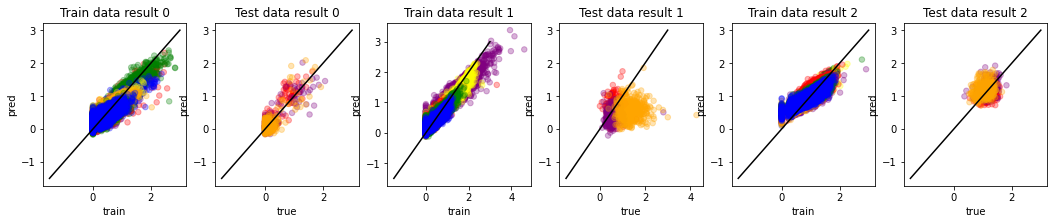

[[14100, 0, array(0.14289868, dtype=float32), array(0.19012661, dtype=float32)], [14100, 1, array(0.1400814, dtype=float32), array(0.682092, dtype=float32)], [14100, 2, array(0.15897919, dtype=float32), array(0.24904476, dtype=float32)]] 0.433367
[[14200, 0, array(0.14244427, dtype=float32), array(0.19034016, dtype=float32)], [14200, 1, array(0.13882573, dtype=float32), array(0.68032116, dtype=float32)], [14200, 2, array(0.15795319, dtype=float32), array(0.2496151, dtype=float32)]] 0.43257907
[[14300, 0, array(0.14199318, dtype=float32), array(0.19051638, dtype=float32)], [14300, 1, array(0.13761322, dtype=float32), array(0.6821721, dtype=float32)], [14300, 2, array(0.15694703, dtype=float32), array(0.24962555, dtype=float32)]] 0.43357742
[[14400, 0, array(0.14153922, dtype=float32), array(0.19078358, dtype=float32)], [14400, 1, array(0.13636385, dtype=float32), array(0.6824449, dtype=float32)], [14400, 2, array(0.15592507, dtype=float32), array(0.25009462, dtype=float32)]] 0.43384966


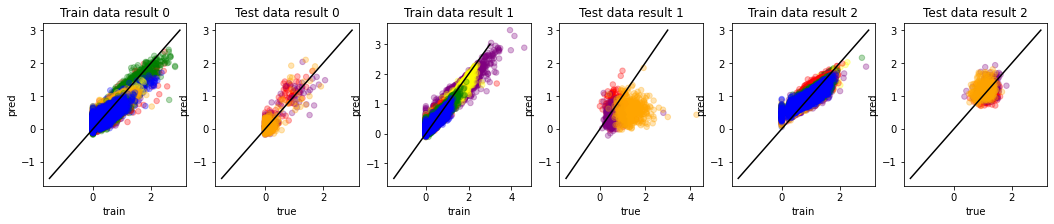

[[15100, 0, array(0.13835828, dtype=float32), array(0.19202588, dtype=float32)], [15100, 1, array(0.12815936, dtype=float32), array(0.6798925, dtype=float32)], [15100, 2, array(0.14890066, dtype=float32), array(0.251843, dtype=float32)]] 0.43303293
[[15200, 0, array(0.13790026, dtype=float32), array(0.1924151, dtype=float32)], [15200, 1, array(0.12701526, dtype=float32), array(0.68050086, dtype=float32)], [15200, 2, array(0.14791378, dtype=float32), array(0.25180894, dtype=float32)]] 0.4334023
[[15300, 0, array(0.13744451, dtype=float32), array(0.19247895, dtype=float32)], [15300, 1, array(0.12588836, dtype=float32), array(0.6821021, dtype=float32)], [15300, 2, array(0.14691803, dtype=float32), array(0.25229836, dtype=float32)]] 0.43434465
[[15400, 0, array(0.13698617, dtype=float32), array(0.1925603, dtype=float32)], [15400, 1, array(0.1247708, dtype=float32), array(0.68225414, dtype=float32)], [15400, 2, array(0.14593698, dtype=float32), array(0.25258404, dtype=float32)]] 0.43449157


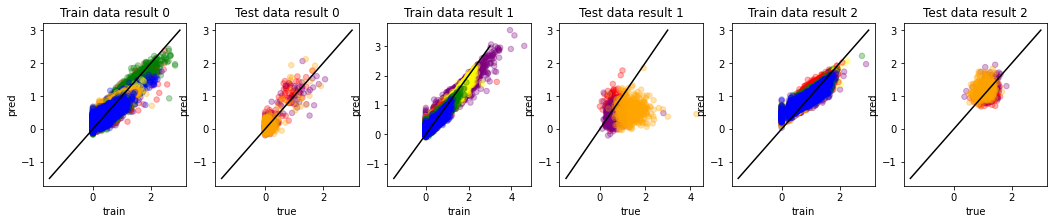

[[16100, 0, array(0.1337679, dtype=float32), array(0.19406033, dtype=float32)], [16100, 1, array(0.11734054, dtype=float32), array(0.68250704, dtype=float32)], [16100, 2, array(0.13912034, dtype=float32), array(0.25393286, dtype=float32)]] 0.4351081
[[16200, 0, array(0.13330892, dtype=float32), array(0.19419675, dtype=float32)], [16200, 1, array(0.11631334, dtype=float32), array(0.68273556, dtype=float32)], [16200, 2, array(0.13816883, dtype=float32), array(0.253931, dtype=float32)]] 0.4352475
[[16300, 0, array(0.13284549, dtype=float32), array(0.19431964, dtype=float32)], [16300, 1, array(0.11531119, dtype=float32), array(0.6831513, dtype=float32)], [16300, 2, array(0.13721623, dtype=float32), array(0.25418556, dtype=float32)]] 0.43553263
[[16400, 0, array(0.13238482, dtype=float32), array(0.19453055, dtype=float32)], [16400, 1, array(0.11433066, dtype=float32), array(0.6842619, dtype=float32)], [16400, 2, array(0.1362648, dtype=float32), array(0.254654, dtype=float32)]] 0.43623585
[[

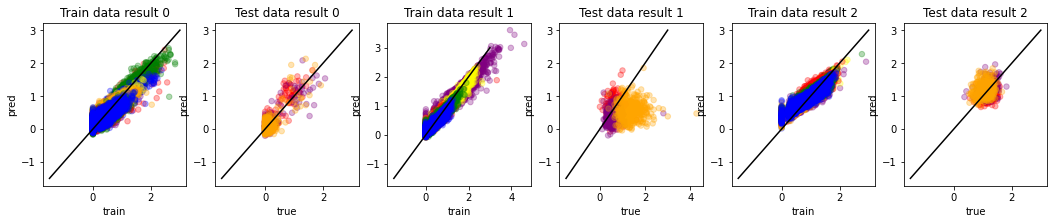

[[17100, 0, array(0.12913822, dtype=float32), array(0.19582625, dtype=float32)], [17100, 1, array(0.10761178, dtype=float32), array(0.6839402, dtype=float32)], [17100, 2, array(0.12974198, dtype=float32), array(0.25583494, dtype=float32)]] 0.4364911
[[17200, 0, array(0.12867413, dtype=float32), array(0.19600576, dtype=float32)], [17200, 1, array(0.10670161, dtype=float32), array(0.6849856, dtype=float32)], [17200, 2, array(0.12882964, dtype=float32), array(0.25611368, dtype=float32)]] 0.43711847
[[17300, 0, array(0.12821427, dtype=float32), array(0.19613849, dtype=float32)], [17300, 1, array(0.10582131, dtype=float32), array(0.68504685, dtype=float32)], [17300, 2, array(0.12792838, dtype=float32), array(0.2562902, dtype=float32)]] 0.43720478
[[17400, 0, array(0.12775189, dtype=float32), array(0.19627413, dtype=float32)], [17400, 1, array(0.10492462, dtype=float32), array(0.684023, dtype=float32)], [17400, 2, array(0.12704411, dtype=float32), array(0.25598308, dtype=float32)]] 0.4366304

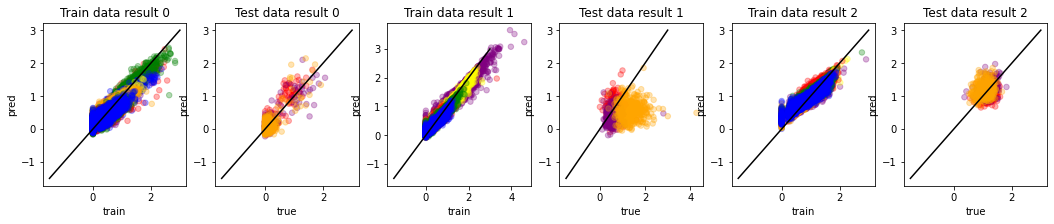

[[18100, 0, array(0.12449384, dtype=float32), array(0.1975419, dtype=float32)], [18100, 1, array(0.09898648, dtype=float32), array(0.6820748, dtype=float32)], [18100, 2, array(0.12085392, dtype=float32), array(0.25765753, dtype=float32)]] 0.4361331
[[18200, 0, array(0.12402848, dtype=float32), array(0.19780478, dtype=float32)], [18200, 1, array(0.09813151, dtype=float32), array(0.6839314, dtype=float32)], [18200, 2, array(0.11999255, dtype=float32), array(0.25801197, dtype=float32)]] 0.4372105
[[18300, 0, array(0.12356217, dtype=float32), array(0.19798404, dtype=float32)], [18300, 1, array(0.09732857, dtype=float32), array(0.68470794, dtype=float32)], [18300, 2, array(0.11913767, dtype=float32), array(0.2581342, dtype=float32)]] 0.43766648
[[18400, 0, array(0.12309895, dtype=float32), array(0.19802982, dtype=float32)], [18400, 1, array(0.09653585, dtype=float32), array(0.68581504, dtype=float32)], [18400, 2, array(0.11828993, dtype=float32), array(0.25830272, dtype=float32)]] 0.4382839

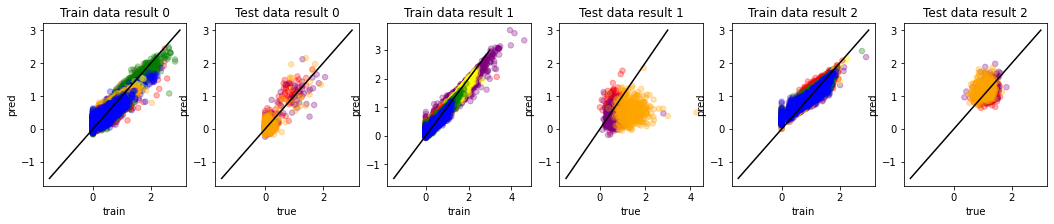

[[19100, 0, array(0.11984562, dtype=float32), array(0.1992384, dtype=float32)], [19100, 1, array(0.09121497, dtype=float32), array(0.68363726, dtype=float32)], [19100, 2, array(0.11250063, dtype=float32), array(0.25953335, dtype=float32)]] 0.43757415
[[19200, 0, array(0.11938515, dtype=float32), array(0.19935504, dtype=float32)], [19200, 1, array(0.09048083, dtype=float32), array(0.68421954, dtype=float32)], [19200, 2, array(0.11170182, dtype=float32), array(0.2599981, dtype=float32)]] 0.43798694
[[19300, 0, array(0.11891449, dtype=float32), array(0.19978972, dtype=float32)], [19300, 1, array(0.08974214, dtype=float32), array(0.6855468, dtype=float32)], [19300, 2, array(0.1108956, dtype=float32), array(0.25983977, dtype=float32)]] 0.4387129
[[19400, 0, array(0.1184578, dtype=float32), array(0.19967884, dtype=float32)], [19400, 1, array(0.08907461, dtype=float32), array(0.68525076, dtype=float32)], [19400, 2, array(0.11013892, dtype=float32), array(0.2596039, dtype=float32)]] 0.4384953


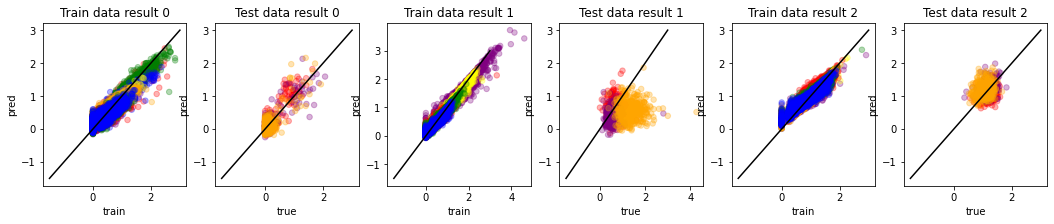

[[20100, 0, array(0.11521394, dtype=float32), array(0.20081046, dtype=float32)], [20100, 1, array(0.08432321, dtype=float32), array(0.68419415, dtype=float32)], [20100, 2, array(0.10472416, dtype=float32), array(0.2614837, dtype=float32)]] 0.43848988
[[20200, 0, array(0.11474989, dtype=float32), array(0.20112488, dtype=float32)], [20200, 1, array(0.08368365, dtype=float32), array(0.6837137, dtype=float32)], [20200, 2, array(0.10398005, dtype=float32), array(0.26132077, dtype=float32)]] 0.43825567
[[20300, 0, array(0.11430064, dtype=float32), array(0.20127362, dtype=float32)], [20300, 1, array(0.08304191, dtype=float32), array(0.68537575, dtype=float32)], [20300, 2, array(0.10325448, dtype=float32), array(0.2614153, dtype=float32)]] 0.43916166
[[20400, 0, array(0.11384398, dtype=float32), array(0.20113662, dtype=float32)], [20400, 1, array(0.08242059, dtype=float32), array(0.6843342, dtype=float32)], [20400, 2, array(0.10252879, dtype=float32), array(0.26131967, dtype=float32)]] 0.43858

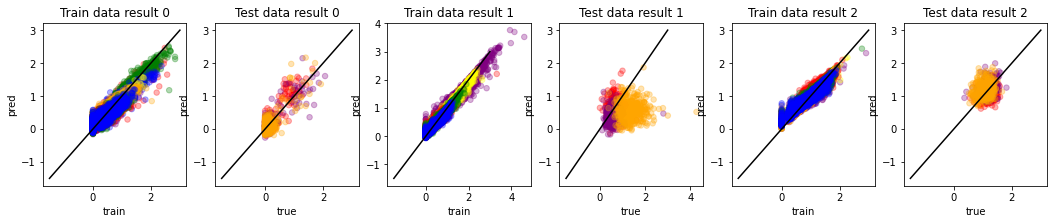

[[21100, 0, array(0.11063311, dtype=float32), array(0.20240325, dtype=float32)], [21100, 1, array(0.0782198, dtype=float32), array(0.6855932, dtype=float32)], [21100, 2, array(0.09756052, dtype=float32), array(0.26223212, dtype=float32)]] 0.43960997
[[21200, 0, array(0.11017925, dtype=float32), array(0.2024668, dtype=float32)], [21200, 1, array(0.07763396, dtype=float32), array(0.68491775, dtype=float32)], [21200, 2, array(0.09687347, dtype=float32), array(0.26259822, dtype=float32)]] 0.43934152
[[21300, 0, array(0.10972179, dtype=float32), array(0.20269692, dtype=float32)], [21300, 1, array(0.07707843, dtype=float32), array(0.68656075, dtype=float32)], [21300, 2, array(0.09620598, dtype=float32), array(0.26231655, dtype=float32)]] 0.44017482
[[21400, 0, array(0.10927513, dtype=float32), array(0.20267661, dtype=float32)], [21400, 1, array(0.07657732, dtype=float32), array(0.6874594, dtype=float32)], [21400, 2, array(0.09554454, dtype=float32), array(0.26247677, dtype=float32)]] 0.44067

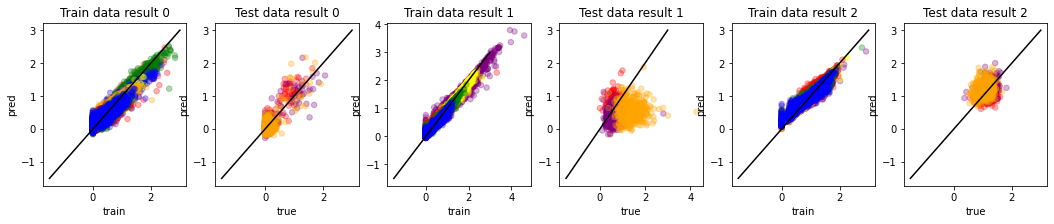

[[22100, 0, array(0.10612093, dtype=float32), array(0.2037606, dtype=float32)], [22100, 1, array(0.0728383, dtype=float32), array(0.68766296, dtype=float32)], [22100, 2, array(0.09099834, dtype=float32), array(0.26317224, dtype=float32)]] 0.44108137
[[22200, 0, array(0.10566942, dtype=float32), array(0.20389524, dtype=float32)], [22200, 1, array(0.07226205, dtype=float32), array(0.6863681, dtype=float32)], [22200, 2, array(0.09034632, dtype=float32), array(0.2635145, dtype=float32)]] 0.44049755
[[22300, 0, array(0.10523036, dtype=float32), array(0.20389843, dtype=float32)], [22300, 1, array(0.07179669, dtype=float32), array(0.6858571, dtype=float32)], [22300, 2, array(0.08972824, dtype=float32), array(0.2637385, dtype=float32)]] 0.44027737
[[22400, 0, array(0.10479216, dtype=float32), array(0.20390154, dtype=float32)], [22400, 1, array(0.0712872, dtype=float32), array(0.68543303, dtype=float32)], [22400, 2, array(0.08911332, dtype=float32), array(0.26379284, dtype=float32)]] 0.44006848

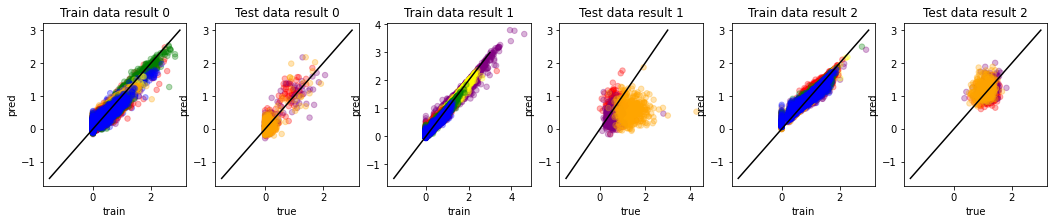

[[23100, 0, array(0.10168736, dtype=float32), array(0.20505668, dtype=float32)], [23100, 1, array(0.06797899, dtype=float32), array(0.68770546, dtype=float32)], [23100, 2, array(0.08495074, dtype=float32), array(0.26434097, dtype=float32)]] 0.4415364
[[23200, 0, array(0.10124145, dtype=float32), array(0.20518751, dtype=float32)], [23200, 1, array(0.06747328, dtype=float32), array(0.68510747, dtype=float32)], [23200, 2, array(0.08436867, dtype=float32), array(0.26453388, dtype=float32)]] 0.440247
[[23300, 0, array(0.1008053, dtype=float32), array(0.20538566, dtype=float32)], [23300, 1, array(0.06704528, dtype=float32), array(0.6868522, dtype=float32)], [23300, 2, array(0.08381271, dtype=float32), array(0.26482457, dtype=float32)]] 0.44124112
[[23400, 0, array(0.10037778, dtype=float32), array(0.20529723, dtype=float32)], [23400, 1, array(0.06664844, dtype=float32), array(0.6874106, dtype=float32)], [23400, 2, array(0.08328575, dtype=float32), array(0.26414916, dtype=float32)]] 0.4413823

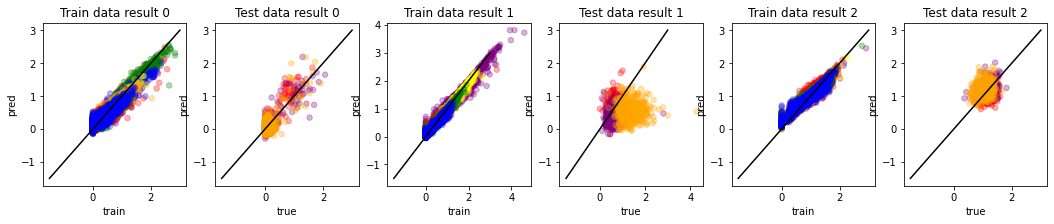

KeyboardInterrupt: 

In [39]:
num_epochs = 50000
learning_rate = 0.001
latent_dim = 50
loss_fn = F.mse_loss
batch_size = 50000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = Autoencoder()
# model.load_state_dict(torch.load('Batch_feature_norm_model'))
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
train_pred_np, train_output_np, val_pred_np, val_output_np = fit(num_epochs, model, loss_fn, train_input, train_output, val_input, val_output, test_input, test_output)